In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

from mtcnn import MTCNN

In [2]:
# Путь к корневой папке
root_folder = 'faces'
model_weights_path = 'model_weights.pth'
batch_size = 64
age_diff = 5
epochs = 100
losses = []

In [3]:
def GetImagesFromPath(path, count=1000):
    images = []
    ages = []
    i = 0
    # Обходим все подпапки и файлы в корневой папке
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            # Проверяем, является ли файл изображением
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Проверяем, соответствует ли имя файла ожидаемому формату
                match = re.match(r'^\d+_[01]_[0-4]_\d{17}', file)
                if match is None:
                    continue
                
                # Полный путь к файлу
                file_path = os.path.join(dirpath, file)
                
                # Читаем изображение
                image = cv2.imread(file_path)
                
                # Извлекаем информацию из названия файла
                name_parts = file.split('_')
                age = int(name_parts[0])
                
                # Добавляем изображение и информацию в список
                images.append(cv2.resize(image, (64, 64)))
                ages.append(age)
                i += 1
            if(i >= count):
                return np.array(images), np.array(ages)
    
    return np.array(images), np.array(ages)

In [4]:
def ShowImages(images, count, rows, cols):
    # Отображаем первые 10 изображений
    for i in range(count):
        # Создаем подграфик для каждого изображения
        plt.subplot(rows, cols, i+1)
        
        # Удаляем оси
        plt.axis('off')
        
        # Отображаем изображение
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    # Показываем все подграфики
    plt.show()

In [5]:
images, ages = GetImagesFromPath(root_folder)

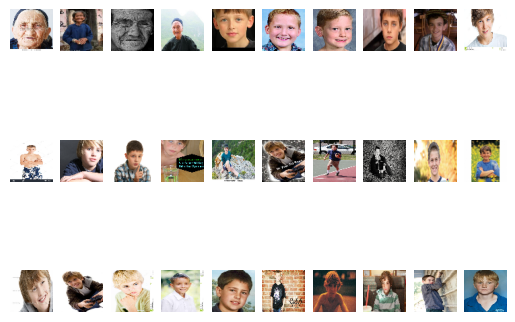

In [6]:
ShowImages(images, 30, 3, 10)

In [7]:
cropped_images = []
cropped_ages = []

In [8]:
detector = MTCNN()
for image in images:
    # Детектирование лиц на изображении
    result = detector.detect_faces(image)
    isCropped = False
    for i in range(len(result)):
        (x, y, w, h) = result[i]['box']
    # Обрезка изображения до области с лицом
        face_image = image[y:y+h, x:x+w]
        if face_image.size != 0:
            cropped_images.append(cv2.resize(face_image, (64, 64)))
            isCropped = True
            break



1/1 [==============================] - 0s 30ms/step


In [9]:
cropped_images = np.array(cropped_images)

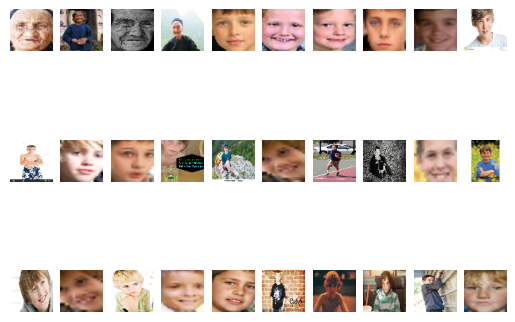

In [10]:
ShowImages(cropped_images, 30, 3, 10)

In [11]:
# предположим, что X - это ваши данные, а y - это ваши метки
train_images, test_images, train_ages, test_ages = train_test_split(cropped_images, ages[0:len(cropped_images)], test_size=0.1, train_size=0.9, random_state=42)

In [12]:
class AgePredictor(nn.Module):
    def __init__(self):
        super(AgePredictor, self).__init__()
        self.conv1 = nn.Conv2d(64, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        #self.conv2 = nn.Conv2d(32, batch_size, 3, padding=1)
        self.fc1 = nn.Linear(batch_size * 16 * 16, 32) 
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
       # x = F.relu(self.conv2(x))
        x = x.view(-1, batch_size * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        return x


In [13]:
class AgeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets):
        return (torch.abs(outputs - targets)).mean()

In [14]:
# Компиляция модели
model = AgePredictor()
#if(os.path.isfile(model_weights_path)):
#    model.load_state_dict(torch.load(model_weights_path))
criterion = AgeLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
tensor_images = torch.Tensor(train_images)
tensor_ages = torch.Tensor(train_ages)
train_dataset = TensorDataset(tensor_images, tensor_ages)
train_dataloader = DataLoader(train_dataset)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

print(len(train_loader))

15


In [16]:
def train(epochs, model, criterion, optimizer, train_loader, eps):
    for epoch in range(epochs):
        loss = 0
        for batch_features, targets in train_loader:
            if(len(batch_features) != batch_size):
                continue
            batch_features = batch_features.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, targets)
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        losses.append(loss)
        # display the epoch training loss
        #if((epoch+1) % 10 == 0):
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
        if loss < eps:
            break
    
    return model

In [17]:
model = train(epochs, model, criterion, optimizer, train_loader, age_diff)

epoch : 1/100, loss = 20.430912
epoch : 2/100, loss = 13.585417
epoch : 3/100, loss = 13.587500
epoch : 4/100, loss = 13.591667
epoch : 5/100, loss = 13.591667
epoch : 6/100, loss = 13.760102
epoch : 7/100, loss = 14.254237
epoch : 8/100, loss = 13.581250
epoch : 9/100, loss = 13.579167
epoch : 10/100, loss = 13.582292
epoch : 11/100, loss = 15.817615
epoch : 12/100, loss = 13.580208
epoch : 13/100, loss = 13.586458
epoch : 14/100, loss = 13.586458
epoch : 15/100, loss = 13.578125
epoch : 16/100, loss = 13.583333
epoch : 17/100, loss = 13.580208
epoch : 18/100, loss = 13.486458
epoch : 19/100, loss = 13.582292
epoch : 20/100, loss = 13.587500
epoch : 21/100, loss = 13.579771
epoch : 22/100, loss = 13.586458
epoch : 23/100, loss = 13.583876
epoch : 24/100, loss = 13.578125
epoch : 25/100, loss = 13.586458
epoch : 26/100, loss = 13.585417
epoch : 27/100, loss = 13.580208
epoch : 28/100, loss = 13.591667
epoch : 29/100, loss = 13.590625
epoch : 30/100, loss = 13.584849
epoch : 31/100, los

In [18]:
# предположим, что `model` - это ваша обученная модель
torch.save(model.state_dict(), model_weights_path)

In [19]:
test_dataset = TensorDataset(torch.Tensor(test_images), torch.Tensor(test_ages))
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

In [20]:
def accuracy(predicted, actual):
    acc = 0
    for pred, act in zip(predicted, actual):
        if(np.abs(act - pred) <= age_diff):
            acc += 1
    return acc / len(predicted)

In [21]:
# Переводим модель в режим оценки
model.eval()

# Инициализируем переменную для хранения суммы квадратов ошибок
sum_of_squared_errors = 0.0

pred_ages = []

# Не вычисляем градиенты, так как мы не обучаем модель
i = 0
with torch.no_grad():
    right_predicted_ages = 0
    all_ages = 0
    for eval_images, true_ages in test_loader:
        if len(eval_images) != batch_size:
            continue
        # Перемещаем данные на тот же device, на котором находится модель
        eval_images = eval_images.to(device)
        true_ages = true_ages.to(device)
        # Получаем предсказания модели
        predicted_ages = model(eval_images)
        pred_ages.extend(predicted_ages.numpy())

print(accuracy(pred_ages, test_ages))


0.0


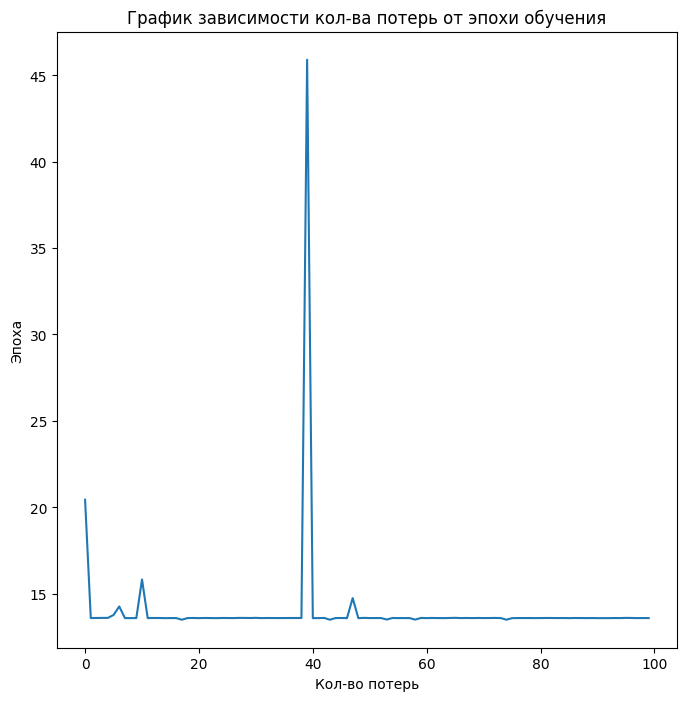

In [22]:
# Создаем данные
x = np.arange(0, len(losses))
y = np.array(losses)

# Создаем график
plt.figure(figsize=(8, 8))
plt.plot(x, y)

# Добавляем подписи к осям
plt.xlabel('Кол-во потерь')
plt.ylabel('Эпоха')

# Добавляем заголовок
plt.title('График зависимости кол-ва потерь от эпохи обучения')

# Отображаем график
plt.show()
